<a href="https://colab.research.google.com/github/alfredqbit/datasciencecoursera/blob/master/sepulvedaadds_8515_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANOVA and MANOVA on Digital Marketing Conversion Dataset

Dataset: `digital_marketing_campaign_dataset.csv`
Source: Kaggle / Opendatabay (Digital Marketing Conversion Dataset)

Goals:
 - One-way ANOVA: PreviousPurchases ~ CampaignChannel
 - Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment
 - MANOVA: (ClickThroughRate, TimeOnSite) ~ CampaignChannel

In [7]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.multivariate.manova import MANOVA
from statsmodels.graphics.factorplots import interaction_plot

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set(style="whitegrid")

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

 # Data loading and preprocessing pipeline

In [8]:
def load_raw_digital_marketing_dataset(
    source: str = "auto",
    local_path: str | None = None,
    download_dir: str = "data"
) -> pd.DataFrame:
    """
    Load `digital_marketing_campaign_dataset.csv` from:
      - a local file,
      - the Kaggle dataset
        `rabieelkharoua/predict-conversion-in-digital-marketing-dataset`,
      - or (optionally) a public raw URL.

    Parameters
    ----------
    source : {'auto', 'local', 'kaggle', 'github'}
        'auto'  : try local_path, then Kaggle path (if on Kaggle),
                  then GitHub raw mirror.
        'local' : require local_path to be a valid file.
        'kaggle': use Kaggle CLI/API to download.
        'github': load from a public raw URL mirror of the same CSV.
    local_path : str or None
        Path to a local CSV file, if available.
    download_dir : str
        Directory where Kaggle downloads / extracted files are stored.

    Returns
    -------
    df : pandas.DataFrame
    """
    filename = "digital_marketing_campaign_dataset.csv"

    # --- 1. AUTO mode: try local, then Kaggle input path, then GitHub raw ---
    if source == "auto":
        # (a) explicit local path
        if local_path is not None and os.path.exists(local_path):
            print(f"Loading dataset from local path: {local_path}")
            return pd.read_csv(local_path)

        # (b) Kaggle built-in path (when running inside Kaggle notebooks)
        kaggle_input = "/kaggle/input/predict-conversion-in-digital-marketing-dataset/digital_marketing_campaign_dataset.csv"
        if os.path.exists(kaggle_input):
            print(f"Loading dataset from Kaggle input path: {kaggle_input}")
            return pd.read_csv(kaggle_input)

        # (c) GitHub raw mirror as a last resort (same CSV mirrored on GitHub)
        github_raw_url = (
            "https://raw.githubusercontent.com/"
            "Elakkiya-U/Digital-marketing-campaign/"
            "main/Digital_Marketing_Campaign_Dataset.csv"
        )
        print(f"Loading dataset from GitHub raw URL: {github_raw_url}")
        return pd.read_csv(github_raw_url)

    # --- 2. LOCAL mode (explicit) ---
    if source == "local":
        if local_path is None:
            raise ValueError("source='local' requires a valid local_path.")
        if not os.path.exists(local_path):
            raise FileNotFoundError(f"Local file not found: {local_path}")
        print(f"Loading dataset from local file: {local_path}")
        return pd.read_csv(local_path)

    # --- 3. KAGGLE mode (non-Kaggle environment, using Kaggle API) ---
    if source == "kaggle":
        # You must have:
        #   pip install kaggle
        #   KAGGLE_USERNAME and KAGGLE_KEY set in your environment,
        #   or kaggle.json configured in ~/.kaggle/
        try:
            from kaggle.api.kaggle_api_extended import KaggleApi
        except ImportError as e:
            raise ImportError(
                "Kaggle API not installed. Run `pip install kaggle` first."
            ) from e

        os.makedirs(download_dir, exist_ok=True)

        dataset_slug = "rabieelkharoua/predict-conversion-in-digital-marketing-dataset"
        print(f"Downloading '{filename}' from Kaggle dataset: {dataset_slug}")

        api = KaggleApi()
        api.authenticate()

        api.dataset_download_file(
            dataset_slug,
            file_name=filename,
            path=download_dir,
            force=True
        )

        zip_path = os.path.join(download_dir, filename + ".zip")
        if os.path.exists(zip_path):
            print(f"Extracting {zip_path} ...")
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(download_dir)
        csv_path = os.path.join(download_dir, filename)
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"Could not find extracted CSV at {csv_path}")
        print(f"Loading dataset from extracted CSV: {csv_path}")
        return pd.read_csv(csv_path)

    # --- 4. GitHub mode (explicit raw HTTP) ---
    if source == "github":
        github_raw_url = (
            "https://raw.githubusercontent.com/"
            "Elakkiya-U/Digital-marketing-campaign/"
            "main/Digital_Marketing_Campaign_Dataset.csv"
        )
        print(f"Loading dataset from GitHub raw URL: {github_raw_url}")
        return pd.read_csv(github_raw_url)

    # If we got here, source was invalid.
    raise ValueError(f"Unknown source '{source}'. Use 'auto', 'local', 'kaggle', or 'github'.")

# Example call (will be used later):
# df = load_and_prepare_data("digital_marketing_campaign_dataset.csv")

# One-way ANOVA pipeline: PreviousPurchases ~ CampaignChannel

We create three income-based segments (Low, Medium, High)
via tertiles, to use as a factor in the two-way ANOVA.

In [9]:
def run_oneway_anova_purchases(df: pd.DataFrame, fig_dir: str = FIG_DIR):
    """
    Run one-way ANOVA: PreviousPurchases ~ CampaignChannel,
    check assumptions, and export diagnostic plots.
    """
    if "PreviousPurchases" not in df.columns or "CampaignChannel" not in df.columns:
        raise ValueError("Required columns 'PreviousPurchases' or 'CampaignChannel' missing.")

    # Drop rows with missing values relevant to this analysis
    df_1way = df.dropna(subset=["PreviousPurchases", "CampaignChannel"])

    # Fit ANOVA model
    model = ols("PreviousPurchases ~ C(CampaignChannel)", data=df_1way).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("One-way ANOVA: PreviousPurchases ~ CampaignChannel")
    display(anova_table)

    resid = model.resid
    fitted = model.fittedvalues

    # Levene's test for homogeneity of variance
    groups = [g["PreviousPurchases"].values for _, g in df_1way.groupby("CampaignChannel")]
    lev_stat, lev_p = stats.levene(*groups)
    print(f"\nLevene's test: stat={lev_stat:.3f}, p={lev_p:.3f}")

    # Shapiro-Wilk for normality of residuals
    sh_stat, sh_p = stats.shapiro(resid)
    print(f"Shapiro-Wilk (residuals): stat={sh_stat:.3f}, p={sh_p:.3f}")

    # Q-Q plot for residuals
    sm.qqplot(resid, line="45")
    plt.title("One-way ANOVA Residuals Q-Q Plot")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "oneway_resid_qq.png"), dpi=300)
    plt.show()

    # Residuals vs fitted
    plt.figure()
    plt.scatter(fitted, resid, alpha=0.6)
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("One-way ANOVA: Residuals vs Fitted")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "oneway_resid_vs_fitted.png"), dpi=300)
    plt.show()

    # Boxplot of PreviousPurchases by CampaignChannel
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="CampaignChannel", y="PreviousPurchases", data=df_1way)
    plt.title("Previous Purchases by Campaign Channel")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "box_purchases_by_channel.png"), dpi=300)
    plt.show()

    return model, anova_table

# Two-way ANOVA pipeline: ClickThroughRate ~ CampaignType * IncomeSegment

In [10]:
def run_twoway_anova_ctr(df: pd.DataFrame, fig_dir: str = FIG_DIR):
    """
    Run two-way ANOVA:
      ClickThroughRate ~ CampaignType * IncomeSegment
    Check assumptions and export interaction and diagnostic plots.
    """
    required = ["ClickThroughRate", "CampaignType", "IncomeSegment"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for two-way ANOVA: {missing}")

    df_2way = df.dropna(subset=required)

    # Fit two-way ANOVA model with interaction
    formula = "ClickThroughRate ~ C(CampaignType) * C(IncomeSegment)"
    model = ols(formula, data=df_2way).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    print("Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment")
    display(anova_table)

    resid = model.resid

    # Shapiro-Wilk test for residuals
    sh_stat, sh_p = stats.shapiro(resid)
    print(f"\nShapiro-Wilk (two-way residuals): stat={sh_stat:.3f}, p={sh_p:.3f}")

    # Levene's test across CampaignType x IncomeSegment cells
    cells = [g["ClickThroughRate"].values
             for _, g in df_2way.groupby(["CampaignType", "IncomeSegment"])]
    lev_stat, lev_p = stats.levene(*cells)
    print(f"Levene's test (two-way): stat={lev_stat:.3f}, p={lev_p:.3f}")

    # Interaction plot
    plt.figure(figsize=(8, 5))
    interaction_plot(
        df_2way["CampaignType"],
        df_2way["IncomeSegment"],
        df_2way["ClickThroughRate"],
        markers=["o", "s", "D"],
        ms=6
    )
    plt.ylabel("Mean ClickThroughRate")
    plt.title("Interaction: CampaignType x IncomeSegment on CTR")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "interaction_ctr_adtype_segment.png"), dpi=300)
    plt.show()

    # Q-Q plot for residuals
    sm.qqplot(resid, line="45")
    plt.title("Two-way ANOVA Residuals Q-Q Plot (CTR)")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "twoway_ctr_qqplot.png"), dpi=300)
    plt.show()

    # Residuals vs fitted
    plt.figure()
    plt.scatter(model.fittedvalues, resid, alpha=0.5)
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("Two-way ANOVA: CTR Residuals vs Fitted")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "twoway_ctr_resid_fitted.png"), dpi=300)
    plt.show()

    return model, anova_table

# MANOVA pipeline: (ClickThroughRate, TimeOnSite) ~ CampaignChannel
#
Includes:
 - MANOVA via statsmodels
 - Assumption checks (Shapiro, Box's M)
 - Canonical discriminant visualization via sklearn Pipeline (StandardScaler + LDA)

In [11]:
from numpy.linalg import det, inv
from scipy.stats import chi2

def box_m_test(df_y: pd.DataFrame, group_labels: np.ndarray):
    """
    Box's M test for equality of covariance matrices across groups.
    """
    y = df_y.values
    groups = np.unique(group_labels)
    p = y.shape[1]
    N = y.shape[0]

    covs = []
    ns = []
    for g in groups:
        Yg = y[group_labels == g]
        ns.append(Yg.shape[0])
        covs.append(np.cov(Yg, rowvar=False))

    ns = np.array(ns)
    covs = np.array(covs)

    # Pooled covariance
    Sp = sum((ns[i] - 1) * covs[i] for i in range(len(groups))) / (N - len(groups))

    M = (N - len(groups)) * np.log(det(Sp)) - sum(
        (ns[i] - 1) * np.log(det(covs[i])) for i in range(len(groups))
    )

    # Correction factor
    C = ((2 * p**2 + 3 * p - 1) /
         (6 * (p + 1) * (len(groups) - 1))) * \
        (sum(1 / (ns[i] - 1) for i in range(len(groups))) -
         1 / (N - len(groups)))

    chi2_approx = M * (1 - C)
    df_val = (len(groups) - 1) * p * (p + 1) / 2
    p_value = 1 - chi2.cdf(chi2_approx, df_val)

    return M, chi2_approx, df_val, p_value


def run_manova_and_canonical(df: pd.DataFrame, fig_dir: str = FIG_DIR):
    """
    Run MANOVA:
      (ClickThroughRate, TimeOnSite) ~ CampaignChannel
    + assumption checks
    + canonical discriminant visualization via sklearn Pipeline (StandardScaler + LDA).
    """
    required = ["ClickThroughRate", "TimeOnSite", "CampaignChannel"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns for MANOVA: {missing}")

    df_manova = df.dropna(subset=required)

    # MANOVA using statsmodels
    formula = "ClickThroughRate + TimeOnSite ~ C(CampaignChannel)"
    manova = MANOVA.from_formula(formula, data=df_manova)
    print("MANOVA results (CTR, TimeOnSite ~ CampaignChannel):")
    print(manova.mv_test())

    # Assumption checks: univariate Shapiro-Wilk for each DV
    for dv in ["ClickThroughRate", "TimeOnSite"]:
        stat, pval = stats.shapiro(df_manova[dv])
        print(f"\nShapiro-Wilk for {dv}: stat={stat:.3f}, p={pval:.3f}")

    # Box's M test for equality of covariance matrices
    Y = df_manova[["ClickThroughRate", "TimeOnSite"]]
    groups = df_manova["CampaignChannel"].values
    M, chi2_val, df_box, p_box = box_m_test(Y, groups)
    print(f"\nBox's M test: M={M:.3f}, chi2={chi2_val:.3f}, df={df_box:.0f}, p={p_box:.3f}")

    # Follow-up univariate ANOVAs
    for dv in ["ClickThroughRate", "TimeOnSite"]:
        print(f"\nUnivariate ANOVA: {dv} ~ CampaignChannel")
        model_dv = ols(f"{dv} ~ C(CampaignChannel)", data=df_manova).fit()
        anova_dv = sm.stats.anova_lm(model_dv, typ=2)
        display(anova_dv)

    # Canonical discriminant scores via sklearn Pipeline: StandardScaler + LDA
    # This is the explicit sklearn "pipeline" part.
    lda_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("lda", LinearDiscriminantAnalysis(n_components=2))
    ])

    Y_numeric = Y.values
    scores = lda_pipeline.fit_transform(Y_numeric, groups)

    can_df = pd.DataFrame(scores, columns=["Can1", "Can2"])
    can_df["CampaignChannel"] = groups

    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x="Can1", y="Can2",
        hue="CampaignChannel",
        data=can_df,
        s=60, alpha=0.8
    )
    plt.axhline(0, color="gray", linewidth=0.8)
    plt.axvline(0, color="gray", linewidth=0.8)
    plt.title("Canonical Score Plot: CTR & TimeOnSite by CampaignChannel")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_dir, "manova_canonical_scatter.png"), dpi=300)
    plt.show()

    return manova, can_df

# Run the full analysis pipeline

Loading dataset from GitHub raw URL: https://raw.githubusercontent.com/Elakkiya-U/Digital-marketing-campaign/main/Digital_Marketing_Campaign_Dataset.csv
Data preview after preprocessing:


,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,...,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,IncomeSegment
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,...,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1,High
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,...,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1,Low
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,...,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1,Medium
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,...,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1,Low
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,...,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1,Medium



Running one-way ANOVA pipeline...
One-way ANOVA: PreviousPurchases ~ CampaignChannel


,sum_sq,df,F,PR(>F)
C(CampaignChannel),19.51713,4.0,0.584848,0.673615
Residual,66700.80087,7995.0,NaN,NaN



Levene's test: stat=0.341, p=0.850
Shapiro-Wilk (residuals): stat=0.939, p=0.000


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8000.
  res = hypotest_fun_out(*samples, **kwds)


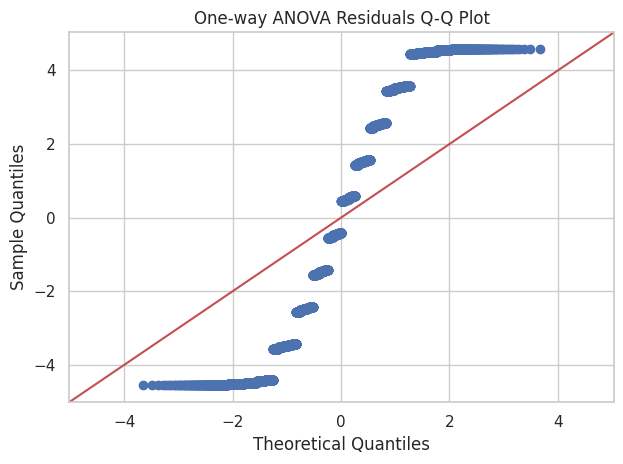

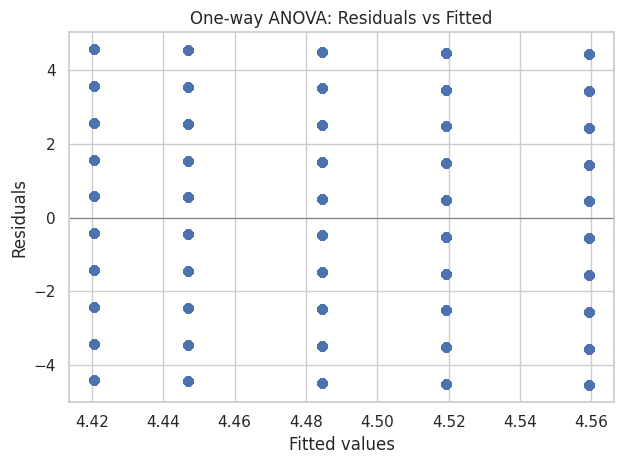

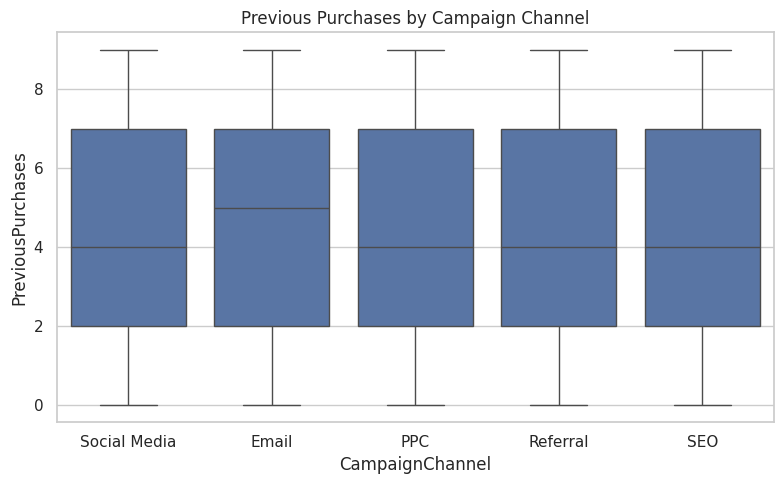


Running two-way ANOVA pipeline...
Two-way ANOVA: ClickThroughRate ~ CampaignType * IncomeSegment


,sum_sq,df,F,PR(>F)
C(CampaignType),0.024633,3.0,1.163461,0.322083
C(IncomeSegment),0.016173,2.0,1.145788,0.318026
C(CampaignType):C(IncomeSegment),0.035065,6.0,0.828095,0.547889
Residual,56.374903,7988.0,NaN,NaN



Shapiro-Wilk (two-way residuals): stat=0.955, p=0.000
Levene's test (two-way): stat=1.158, p=0.311


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8000.
  res = hypotest_fun_out(*samples, **kwds)
/tmp/ipython-input-2413957834.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, g in df_2way.groupby(["CampaignType", "IncomeSegment"])]
/usr/local/lib/python3.12/dist-packages/statsmodels/graphics/factorplots.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_data = data.groupby(['trace', 'x']).aggregate(func).reset_index()
/usr/local/lib/python3.12/dist-packages/statsm

<Figure size 800x500 with 0 Axes>

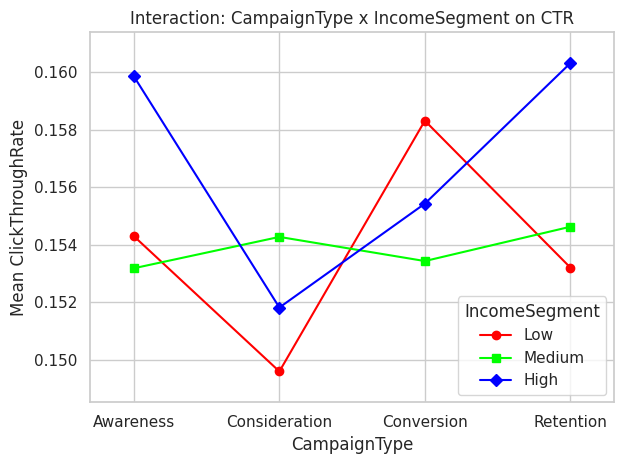

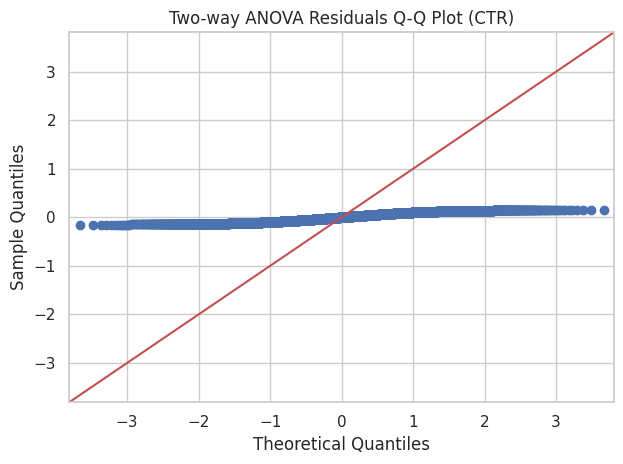

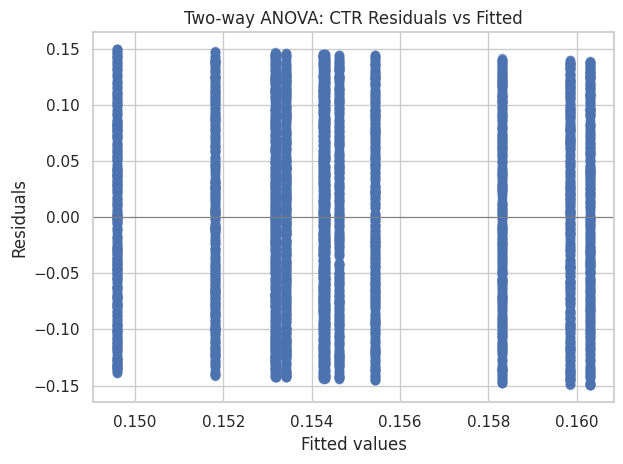


Running MANOVA + canonical discriminant pipeline...
MANOVA results (CTR, TimeOnSite ~ CampaignChannel):
                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.4306 2.0000 7994.0000 5285.7746 0.0000
         Pillai's trace 0.5694 2.0000 7994.0000 5285.7746 0.0000
 Hotelling-Lawley trace 1.3224 2.0000 7994.0000 5285.7746 0.0000
    Roy's greatest root 1.3224 2.0000 7994.0000 5285.7746 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
    C(CampaignChannel)   Value  Num DF   Den DF   F Value Pr > F
----------------------------------------------------------------
     

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8000.
  res = hypotest_fun_out(*samples, **kwds)


,sum_sq,df,F,PR(>F)
C(CampaignChannel),0.043195,4.0,1.530566,0.190315
Residual,56.407430,7995.0,NaN,NaN



Univariate ANOVA: TimeOnSite ~ CampaignChannel


,sum_sq,df,F,PR(>F)
C(CampaignChannel),77.376906,4.0,1.082068,0.363477
Residual,142927.380366,7995.0,NaN,NaN


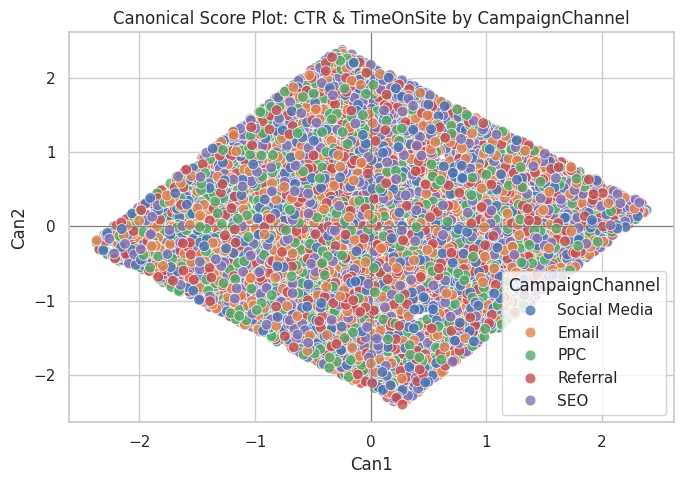


Pipeline complete. Figures saved in the 'figures' subdirectory.


In [14]:
df = load_raw_digital_marketing_dataset()

# Create IncomeSegment for two-way ANOVA
df['IncomeSegment'] = pd.qcut(
    df['Income'],
    q=3,
    labels=['Low', 'Medium', 'High'],
    duplicates='drop'
)

print("Data preview after preprocessing:")
display(df.head())

print("\nRunning one-way ANOVA pipeline...")
model_1way, anova_1way = run_oneway_anova_purchases(df)

print("\nRunning two-way ANOVA pipeline...")
model_2way, anova_2way = run_twoway_anova_ctr(df)

print("\nRunning MANOVA + canonical discriminant pipeline...")
manova_res, canonical_scores_df = run_manova_and_canonical(df)

print("\nPipeline complete. Figures saved in the 'figures' subdirectory.")